# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [15]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import nsfg
import first
import thinkstats2
import thinkplot

## The Limits of PMFs

Probability mass functions work well if the number of values is relatively small. As the number of values increase, however, the probability associated with each value gets smaller and the effect of random noise increases. 

See the PMF plot below to see how this affects `totalwgt_lb` values.

Binning can be used to smooth out some of the peaks and valleys, howerever binning is hard to get right and meaningful information can be lost in the process.

An alternative to this approach is the cumulative distribution function, or *CDF*. 


## Examples

One more time, I'll load the data from the NSFG.

In [16]:
live, firsts, others = first.MakeFrames()

And compute the distribution of birth weight for first babies and others.

In [17]:
first_wgt = firsts.totalwgt_lb
first_wgt_dropna = first_wgt.dropna()
print('Firsts', len(first_wgt), len(first_wgt_dropna))
 
other_wgt = others.totalwgt_lb
other_wgt_dropna = other_wgt.dropna()
print('Others', len(other_wgt), len(other_wgt_dropna))

first_pmf = thinkstats2.Pmf(first_wgt_dropna, label='first')
other_pmf = thinkstats2.Pmf(other_wgt_dropna, label='other')

Firsts 4413 4363
Others 4735 4675


We can plot the PMFs on the same scale, but it is hard to see if there is a difference.

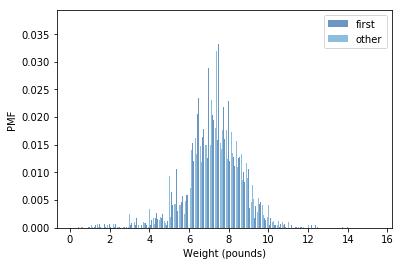

In [18]:
width = 0.4 / 16

# plot PMFs of birth weights for first babies and others
thinkplot.PrePlot(2)
thinkplot.Hist(first_pmf, align='right', width=width)
thinkplot.Hist(other_pmf, align='left', width=width)
thinkplot.Config(xlabel='Weight (pounds)', ylabel='PMF')

## Percentiles

*Percentile Rank* (in the context of a standardized test score) is the fraction of people whore scored lower than you (or the same). In other words, if you're in the 90th percentile, you scored better than 90% of other test takers.

`PercentileRank` computes the fraction of `scores` less than or equal to `your_score`.

In [19]:
def PercentileRank(scores, your_score):
    count = 0
    for score in scores:
        if score <= your_score:
            count += 1

    percentile_rank = 100.0 * count / len(scores)
    return percentile_rank

If this is the list of scores.

In [20]:
t = [55, 66, 77, 88, 99]

And you got the 88, your percentile rank is 80.

In [21]:
PercentileRank(t, 88)

80.0

If you are given a value, it is easy to find its percentile rank; going the other way is a bit more complicated. One option is to sort the list of values and search for the one you want.

`Percentile` takes a percentile rank and computes the corresponding percentile. 

In [22]:
def Percentile(scores, percentile_rank):
    scores.sort()
    for score in scores:
        if PercentileRank(scores, score) >= percentile_rank:
            return score

The median is the 50th percentile, which is 77.

In [23]:
Percentile(t, 50)

77

The result of the above calculation is a __percentile__. However, the implementation of this calulcation is very efficient (repeated loops, I'm guessing). Here's a more efficient way to compute percentiles.

In [24]:
def Percentile2(scores, percentile_rank):
    scores.sort()
    index = percentile_rank * (len(scores)-1) // 100
    return scores[index]

Let's hope we get the same answer.

In [25]:
Percentile2(t, 50)

77

The difference between "percentile" and "percentile rank" can be confusing , and people do not always use the terms precisely. In summary, `PercentileRank` takes a value and computes its percentile rank; `Percentile` takes a percetile rank and computes the corresponding value. 

## CDFs

The Cumulative Distribution Function (CDF) is almost the same as `PercentileRank` and is a function that maps from a value to its percentile rank.  The only difference is that the result is 0-1 instead of 0-100.

The CDF is a function of $x$, where $x$ is any value that might appear in the distribution. To evaluate CDF($x$) for a paricular value of $x$, we compute the fraction of values in the distribution less than or equal to $x$. Here's what that function looks like with a sequence $t$, and a value $x$:

In [26]:
def EvalCdf(sample, x):
    count = 0.0
    for value in sample:
        if value <= x:
            count += 1

    prob = count / len(sample)
    return prob

In this list

In [27]:
t = [1, 2, 2, 3, 5]

We can evaluate the CDF for various values, including values not in the sample. For instance if $x$ is less than the smallest value in the sample, CDF($x$) is 0. If $x$ is greater than the largest value in the sample, CDF($x$) is 1. The CDF os a sample is a step function.

In [29]:
EvalCdf(t, 0), EvalCdf(t, 1), EvalCdf(t, 2), EvalCdf(t, 3), EvalCdf(t, 4), EvalCdf(t, 5)

(0.0, 0.2, 0.6, 0.8, 0.8, 1.0)

## Representing CDFs

`thinkstats2` provides a class named Cdf that represents CDFs. See page 43 for a description of Cdf `Prob()` and `Value()` methods.

Here's an example using real data, the distribution of pregnancy length for live births.

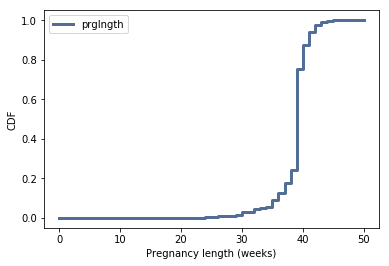

In [30]:
cdf = thinkstats2.Cdf(live.prglngth, label='prglngth')
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Pregnancy length (weeks)', ylabel='CDF', loc='upper left')

One way to read a CDF is to look up percentiles. For example, it looks like ~ %10 of pregnancies are shorter than 36 weeks and ~ 90% are shorter than 41 weeks. The CDF also provides a visual representation of the (shape of the) distribution; common values appear as steep or vertical sections of the CDF (in this case at 39 weeks). There are few values below 30 weeks, so the CDF in this range is flat.

`Cdf` provides `Prob`, which evaluates the CDF; that is, it computes the fraction of values less than or equal to the given value.  For example, 94% of pregnancy lengths are less than or equal to 41.

In [31]:
cdf.Prob(41)

0.9406427634455619

`Value` evaluates the inverse CDF; given a fraction, it computes the corresponding value.  For example, the median is the value that corresponds to 0.5.

In [32]:
cdf.Value(0.5)

39

## Comparing CDFs

In general, CDFs are a good way to visualize and compare distributions. They are not as noisy as PMFs, and if you plot several CDFs on the same axes, any differences between them are apparent. Herre is the code that plots the CDF of birth weights for first babies and others.

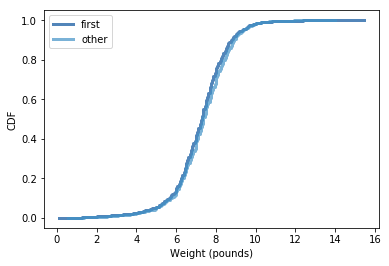

In [33]:
first_cdf = thinkstats2.Cdf(firsts.totalwgt_lb, label='first')
other_cdf = thinkstats2.Cdf(others.totalwgt_lb, label='other')

thinkplot.PrePlot(2)
thinkplot.Cdfs([first_cdf, other_cdf])
thinkplot.Config(xlabel='Weight (pounds)', ylabel='CDF')

In this example, we can see that first babies are slightly, but consistently, lighter than others, with a larger discrepancy above the mean.

We can use the CDF of birth weight to compute percentile-based statistics.

In [ ]:
weights = live.totalwgt_lb
live_cdf = thinkstats2.Cdf(weights, label='live')

Again, the median is the 50th percentile.

In [ ]:
median = live_cdf.Percentile(50)
median

The interquartile range is the interval from the 25th to 75th percentile.

In [ ]:
iqr = (live_cdf.Percentile(25), live_cdf.Percentile(75))
iqr

We can use the CDF to look up the percentile rank of a particular value.  For example, my second daughter was 10.2 pounds at birth, which is near the 99th percentile.

In [ ]:
live_cdf.PercentileRank(10.2)

If we draw a random sample from the observed weights and map each weigh to its percentile rank.

In [ ]:
sample = np.random.choice(weights, 100, replace=True)
ranks = [live_cdf.PercentileRank(x) for x in sample]

The resulting list of ranks should be approximately uniform from 0-1.

In [ ]:
rank_cdf = thinkstats2.Cdf(ranks)
thinkplot.Cdf(rank_cdf)
thinkplot.Config(xlabel='Percentile rank', ylabel='CDF')

That observation is the basis of `Cdf.Sample`, which generates a random sample from a Cdf.  Here's an example.

In [ ]:
resample = live_cdf.Sample(1000)
thinkplot.Cdf(live_cdf)
thinkplot.Cdf(thinkstats2.Cdf(resample, label='resample'))
thinkplot.Config(xlabel='Birth weight (pounds)', ylabel='CDF')

This confirms that the random sample has the same distribution as the original data.

## Exercises

**Exercise:** How much did you weigh at birth? If you don’t know, call your mother or someone else who knows. Using the NSFG data (all live births), compute the distribution of birth weights and use it to find your percentile rank. If you were a first baby, find your percentile rank in the distribution for first babies. Otherwise use the distribution for others. If you are in the 90th percentile or higher, call your mother back and apologize.

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

**Exercise:** The numbers generated by `numpy.random.random` are supposed to be uniform between 0 and 1; that is, every value in the range should have the same probability.

Generate 1000 numbers from `numpy.random.random` and plot their PMF.  What goes wrong?

Now plot the CDF. Is the distribution uniform?

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here